<a href="https://colab.research.google.com/github/HermonaDev/Flora-Guard/blob/main/FloraGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

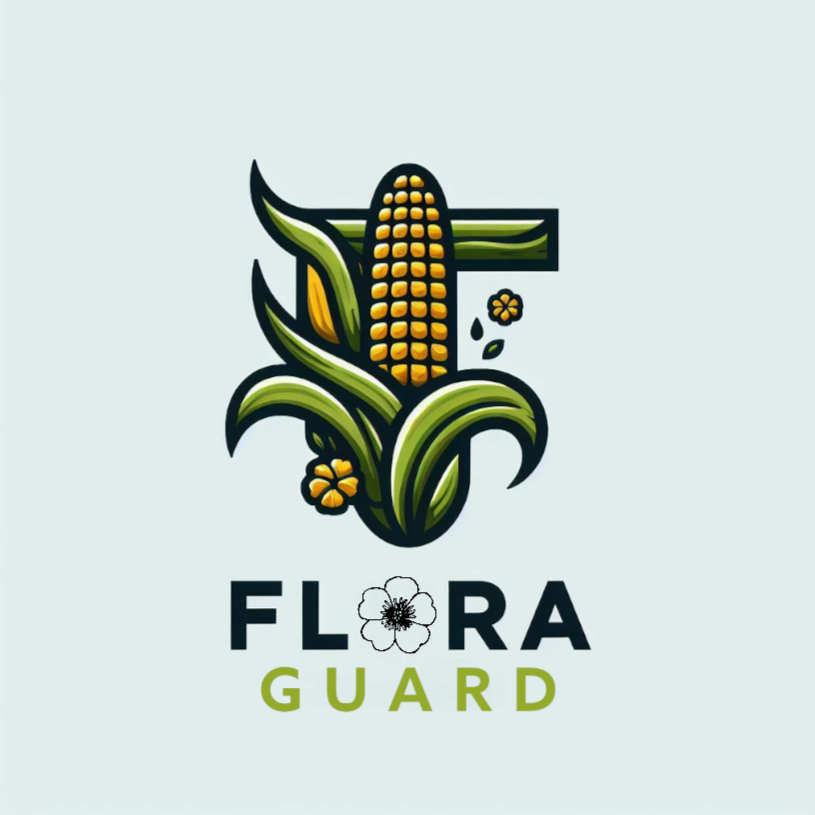

## Background
Getting affected by a disease is very common in plants due to various factors such as fertilizers, cultural practices followed, environmental conditions, etc. These diseases hurt agricultural yield and eventually the economy based on it.
Any technique or method to overcome this problem and getting a warning before the plants are infected would aid farmers to efficiently cultivate crops or plants, both qualitatively and quantitatively. Thus, disease detection in plants plays a very important role in agriculture.

# Introduction

This project tries to build a model using the power of **Keras**, a high-level neural networks API, capable of running on top of TensorFlow. It leverages the **MobileNet architecture**, known for its efficiency and performance, making the model lightweight yet incredibly powerful.

The model is deployed using **TensorFlow**, the world's most comprehensive and flexible platform for machine learning. This allows the model to learn from vast amounts of data and make accurate predictions, all while being scalable and robust.

With our Plant Disease Detection Model, diagnosing plant diseases is as simple as taking a photo. The model analyzes the image, identifies potential diseases, and provides results in seconds. This rapid and precise detection can save crops, increase yield, and ultimately feed more people.

We use a publicly available and quite famous, the PlantVillage Dataset


## Libraries
We import all the necessary libraries required to process the data and build the classification model.

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import PIL
import warnings
import argparse

from tensorflow.python import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Mounting google drive

The first time running the notebook will require you to allow access to your drive from colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/FloraGuard'

/content/drive/My Drive/FloraGuard


In [ ]:
!mkdir config datasets checkpoints models

mkdir: cannot create directory ‘config’: File exists
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘models’: File exists


In [ ]:
cd '/content/drive/My Drive/FloraGuard/config'

/content/drive/My Drive/FloraGuard/config


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/FloraGuard/config"

Download Dataset

In [ ]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:28<00:00, 52.1MB/s]
100% 2.04G/2.04G [00:28<00:00, 76.9MB/s]


Unzip Data

In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  plantvillage-dataset.zip
replace plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pwd

/content/drive/MyDrive/FloraGuard/datasets


Split the Data

In [ ]:
pip install split-folders[full]

In [ ]:
import splitfolders

In [ ]:
input_file="plantvillage dataset/color"
output_file="plantvillage dataset splitted"

In [18]:
splitfolders.ratio(input_file, output=output_file, seed=42, ratio=(.7,.2,.1), group_prefix=None)

Streaming output truncated to the last 5000 lines.
Copying files: 43174 files [51:59, 41.84 files/s]

Copying files: 43179 files [51:59, 42.29 files/s]

Copying files: 43184 files [51:59, 41.80 files/s]

Copying files: 43190 files [51:59, 43.38 files/s]

Copying files: 43197 files [51:59, 49.15 files/s]

Copying files: 43203 files [52:00, 50.64 files/s]

Copying files: 43211 files [52:00, 56.60 files/s]

Copying files: 43217 files [52:00, 53.81 files/s]

Copying files: 43223 files [52:00, 50.86 files/s]

Copying files: 43229 files [52:00, 49.10 files/s]

Copying files: 43234 files [52:00, 47.85 files/s]

Copying files: 43241 files [52:00, 51.80 files/s]

Copying files: 43247 files [52:00, 49.02 files/s]

Copying files: 43254 files [52:01, 54.19 files/s]

Copying files: 43260 files [52:01, 50.84 files/s]

Copying files: 43266 files [52:01, 50.16 files/s]

Copying files: 43272 files [52:01, 48.59 files/s]

Copying files: 43277 files [52:01, 47.88 files/s]

Copying files: 43282 files [52:

In [24]:
base_path = './plantvillage splitted'

train_data_dir = base_path + "/train"
val_data_dir = base_path + "/val"

!dir

plantvillage\ dataset  plantvillage\ dataset\ splitted	plantvillage\ splitted


In [25]:
len(os.listdir(os.path.join(base_path, 'train')))

38

In [26]:
img_size, batch_size, shuffle_size = 224, 64, 1000
img_shape = (img_size, img_size, 3)

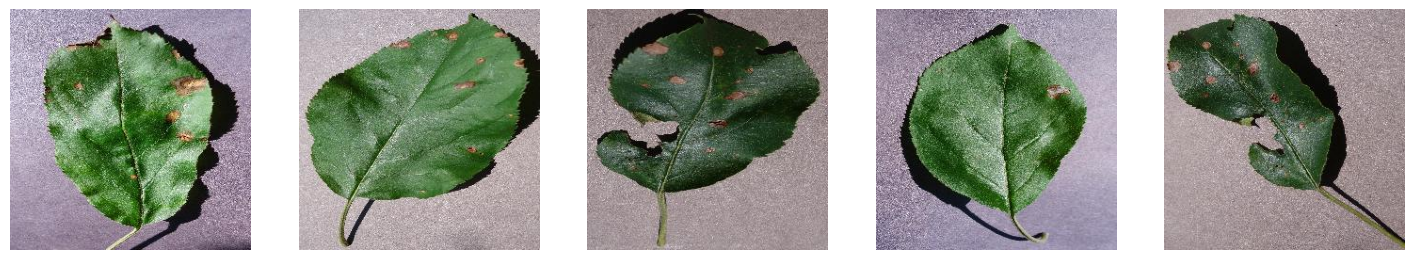

In [27]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
images = os.listdir(os.path.join(base_path, 'train/Apple___Black_rot'))
for _ in range(5):
  ax = axes[_]
  image_path = base_path+'/train/Apple___Black_rot/'+images[_]
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.axis('off')
plt.show()

## Data Augmentation & Preprocessing

In [28]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_datagen = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_datagen = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


## Saving the dataset labels
The generators has an attribute named `class_indices` that contains the data labels that have been supplied by keras.

We save this into a variable since we will require it later.

In [29]:
labels = train_datagen.class_indices

In [ ]:
img = train_datagen.filepaths[np.random.random_integers(low=0, high=train_datagen.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [31]:
import json
with open('/content/drive/My Drive/FloraGuard/labels.json','w') as f:
  json.dump(labels, f)

## Building the model with MobileNetV2
Keras comes packed with some models and for our case we will be using the predesigned MobileNetV2. We will be applying **Transfer Learning**

In [32]:
#The model starts with a standard convolution (Conv2D) layer followed by batch normalization (BatchNormalization) and ReLU activation (ReLU). This is followed by a depthwise convolution (DepthwiseConv2D), which is a space-saving operation that performs a convolution on each input channel separately. The depthwise convolution is also followed by batch normalization and ReLU activation.
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)

mobile_net.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

## Fine Tuning the model


In [33]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(38, activation='softmax')(x)


model = Model(mobile_net.input, x)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [35]:
checkpoint = ModelCheckpoint("pdd_mobilenet2_v1.h5.keras", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [36]:
step_size = 50

In [37]:
model_history = model.fit(
    train_datagen,
    epochs=10,
    steps_per_epoch=step_size,
    validation_data=val_datagen,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/10


Copying files: 833 files [1:17:35,  5.59s/ files]


 1/50 [..............................] - ETA: 8:07 - loss: 3.6804 - acc: 0.0000e+00

 2/50 [>.............................] - ETA: 2:45 - loss: 3.6365 - acc: 0.0312    

 3/50 [>.............................] - ETA: 2:32 - loss: 3.5680 - acc: 0.0521

 4/50 [=>............................] - ETA: 2:10 - loss: 3.4915 - acc: 0.1016

 5/50 [==>...........................] - ETA: 2:00 - loss: 3.4241 - acc: 0.1562

 6/50 [==>...........................] - ETA: 1:53 - loss: 3.4045 - acc: 0.1719

 7/50 [===>..........................] - ETA: 1:47 - loss: 3.3543 - acc: 0.1696

 8/50 [===>..........................] - ETA: 1:47 - loss: 3.3091 - acc: 0.1953

 9/50 [====>.........................] - ETA: 1:49 - loss: 3.2900 - acc: 0.2014

10/50 [=====>........................] - ETA: 1:44 - loss: 3.2451 - acc: 0.2125

11/50 [=====>........................] - ETA: 1:39 - loss: 3.2227 - acc: 0.2131

12/50 [======>.......................] - ETA: 1:35 - loss: 3.1818 - acc: 0.2344

13/50 [======>.......................] - ETA: 1:31 - loss: 3.1558 - acc: 0.2380

14/50 [=======>......................] - ETA: 1:29 - loss: 3.1137 - acc: 0.2522

15/50 [========>.....................] - ETA: 1:29 - loss: 3.1155 - acc: 0.2500

16/50 [========>.....................] - ETA: 1:26 - loss: 3.0438 - acc: 0.2695

17/50 [=========>....................] - ETA: 1:22 - loss: 3.0279 - acc: 0.2721

18/50 [=========>....................] - ETA: 1:19 - loss: 2.9874 - acc: 0.2812

19/50 [==========>...................] - ETA: 1:16 - loss: 2.9724 - acc: 0.2862

20/50 [===========>..................] - ETA: 1:13 - loss: 2.9519 - acc: 0.2875

21/50 [===========>..................] - ETA: 1:11 - loss: 2.9200 - acc: 0.2917

22/50 [============>.................] - ETA: 1:10 - loss: 2.8855 - acc: 0.2997

23/50 [============>.................] - ETA: 1:07 - loss: 2.8762 - acc: 0.3030

24/50 [=============>................] - ETA: 1:04 - loss: 2.8364 - acc: 0.3138

25/50 [==============>...............] - ETA: 1:01 - loss: 2.8042 - acc: 0.3212

26/50 [==============>...............] - ETA: 58s - loss: 2.7700 - acc: 0.3305 

27/50 [===============>..............] - ETA: 56s - loss: 2.7555 - acc: 0.3322

28/50 [===============>..............] - ETA: 54s - loss: 2.7490 - acc: 0.3337

29/50 [================>.............] - ETA: 52s - loss: 2.7230 - acc: 0.3405

30/50 [=================>............] - ETA: 49s - loss: 2.6899 - acc: 0.3490

31/50 [=================>............] - ETA: 47s - loss: 2.6710 - acc: 0.3548

32/50 [==================>...........] - ETA: 44s - loss: 2.6523 - acc: 0.3613

33/50 [==================>...........] - ETA: 42s - loss: 2.6345 - acc: 0.3665

34/50 [===================>..........] - ETA: 40s - loss: 2.6139 - acc: 0.3695

35/50 [====================>.........] - ETA: 37s - loss: 2.5889 - acc: 0.3759

36/50 [====================>.........] - ETA: 35s - loss: 2.5723 - acc: 0.3802

37/50 [=====================>........] - ETA: 32s - loss: 2.5475 - acc: 0.3843

38/50 [=====================>........] - ETA: 30s - loss: 2.5325 - acc: 0.3906

39/50 [======================>.......] - ETA: 27s - loss: 2.5097 - acc: 0.3950

40/50 [=======================>......] - ETA: 25s - loss: 2.4868 - acc: 0.4000

41/50 [=======================>......] - ETA: 22s - loss: 2.4676 - acc: 0.4055

42/50 [========================>.....] - ETA: 20s - loss: 2.4530 - acc: 0.4100

43/50 [========================>.....] - ETA: 17s - loss: 2.4313 - acc: 0.4179

44/50 [=========================>....] - ETA: 15s - loss: 2.4063 - acc: 0.4240

45/50 [==========================>...] - ETA: 12s - loss: 2.3839 - acc: 0.4319

46/50 [==========================>...] - ETA: 10s - loss: 2.3691 - acc: 0.4355

47/50 [===========================>..] - ETA: 7s - loss: 2.3501 - acc: 0.4415 

48/50 [===========================>..] - ETA: 5s - loss: 2.3297 - acc: 0.4460

49/50 [============================>.] - ETA: 2s - loss: 2.3164 - acc: 0.4496

50/50 [==============================] - 191s 4s/step - loss: 2.2900 - acc: 0.4563 - val_loss: 1.8133 - val_acc: 0.5312
Epoch 2/10


 1/50 [..............................] - ETA: 2:48 - loss: 1.5566 - acc: 0.6250

 2/50 [>.............................] - ETA: 2:50 - loss: 1.5162 - acc: 0.6875

 3/50 [>.............................] - ETA: 3:06 - loss: 1.4174 - acc: 0.7083

 4/50 [=>............................] - ETA: 2:40 - loss: 1.3924 - acc: 0.7109

 5/50 [==>...........................] - ETA: 2:24 - loss: 1.3476 - acc: 0.7188

 6/50 [==>...........................] - ETA: 2:13 - loss: 1.3898 - acc: 0.7188

 7/50 [===>..........................] - ETA: 2:06 - loss: 1.3235 - acc: 0.7277

 8/50 [===>..........................] - ETA: 2:11 - loss: 1.2871 - acc: 0.7500

 9/50 [====>.........................] - ETA: 2:11 - loss: 1.2628 - acc: 0.7465

10/50 [=====>........................] - ETA: 2:04 - loss: 1.2758 - acc: 0.7437

11/50 [=====>........................] - ETA: 1:57 - loss: 1.2820 - acc: 0.7358

12/50 [======>.......................] - ETA: 1:51 - loss: 1.2530 - acc: 0.7448

13/50 [======>.......................] - ETA: 1:46 - loss: 1.2429 - acc: 0.7404

14/50 [=======>......................] - ETA: 1:44 - loss: 1.2319 - acc: 0.7411

15/50 [========>.....................] - ETA: 1:42 - loss: 1.2180 - acc: 0.7396

16/50 [========>.....................] - ETA: 1:37 - loss: 1.1869 - acc: 0.7422

17/50 [=========>....................] - ETA: 1:32 - loss: 1.1949 - acc: 0.7353

18/50 [=========>....................] - ETA: 1:28 - loss: 1.1765 - acc: 0.7378

19/50 [==========>...................] - ETA: 1:24 - loss: 1.1826 - acc: 0.7352

20/50 [===========>..................] - ETA: 1:22 - loss: 1.1694 - acc: 0.7344

21/50 [===========>..................] - ETA: 1:20 - loss: 1.1797 - acc: 0.7321

22/50 [============>.................] - ETA: 1:16 - loss: 1.1743 - acc: 0.7301

23/50 [============>.................] - ETA: 1:13 - loss: 1.1726 - acc: 0.7283

24/50 [=============>................] - ETA: 1:09 - loss: 1.1883 - acc: 0.7253

25/50 [==============>...............] - ETA: 1:06 - loss: 1.1841 - acc: 0.7262

26/50 [==============>...............] - ETA: 1:03 - loss: 1.1776 - acc: 0.7248

27/50 [===============>..............] - ETA: 1:01 - loss: 1.1701 - acc: 0.7245

28/50 [===============>..............] - ETA: 59s - loss: 1.1620 - acc: 0.7266 

29/50 [================>.............] - ETA: 56s - loss: 1.1526 - acc: 0.7284

30/50 [=================>............] - ETA: 53s - loss: 1.1475 - acc: 0.7292

31/50 [=================>............] - ETA: 50s - loss: 1.1326 - acc: 0.7319

32/50 [==================>...........] - ETA: 47s - loss: 1.1265 - acc: 0.7314

33/50 [==================>...........] - ETA: 45s - loss: 1.1150 - acc: 0.7339

34/50 [===================>..........] - ETA: 43s - loss: 1.1029 - acc: 0.7371

35/50 [====================>.........] - ETA: 40s - loss: 1.0911 - acc: 0.7384

36/50 [====================>.........] - ETA: 37s - loss: 1.0894 - acc: 0.7396

37/50 [=====================>........] - ETA: 34s - loss: 1.0931 - acc: 0.7382

38/50 [=====================>........] - ETA: 31s - loss: 1.0864 - acc: 0.7410

39/50 [======================>.......] - ETA: 28s - loss: 1.0854 - acc: 0.7420

40/50 [=======================>......] - ETA: 26s - loss: 1.0812 - acc: 0.7414

41/50 [=======================>......] - ETA: 23s - loss: 1.0706 - acc: 0.7439

42/50 [========================>.....] - ETA: 21s - loss: 1.0561 - acc: 0.7478

43/50 [========================>.....] - ETA: 18s - loss: 1.0530 - acc: 0.7456

44/50 [=========================>....] - ETA: 15s - loss: 1.0444 - acc: 0.7479

45/50 [==========================>...] - ETA: 13s - loss: 1.0332 - acc: 0.7500

46/50 [==========================>...] - ETA: 10s - loss: 1.0267 - acc: 0.7527

47/50 [===========================>..] - ETA: 7s - loss: 1.0144 - acc: 0.7560 

48/50 [===========================>..] - ETA: 5s - loss: 1.0052 - acc: 0.7578

49/50 [============================>.] - ETA: 2s - loss: 0.9974 - acc: 0.7602

50/50 [==============================] - 197s 4s/step - loss: 0.9945 - acc: 0.7600 - val_loss: 1.1742 - val_acc: 0.6875
Epoch 3/10


 1/50 [..............................] - ETA: 3:52 - loss: 0.7720 - acc: 0.7500

 2/50 [>.............................] - ETA: 2:53 - loss: 0.8348 - acc: 0.7656

 3/50 [>.............................] - ETA: 2:22 - loss: 0.6930 - acc: 0.8229

 4/50 [=>............................] - ETA: 2:06 - loss: 0.7049 - acc: 0.8125

 5/50 [==>...........................] - ETA: 1:56 - loss: 0.6548 - acc: 0.8313

 6/50 [==>...........................] - ETA: 1:51 - loss: 0.7138 - acc: 0.8177

 7/50 [===>..........................] - ETA: 1:57 - loss: 0.7182 - acc: 0.8125

 8/50 [===>..........................] - ETA: 1:55 - loss: 0.7204 - acc: 0.8203

 9/50 [====>.........................] - ETA: 1:50 - loss: 0.7229 - acc: 0.8264

10/50 [=====>........................] - ETA: 1:45 - loss: 0.7290 - acc: 0.8219

11/50 [=====>........................] - ETA: 1:41 - loss: 0.7261 - acc: 0.8182

12/50 [======>.......................] - ETA: 1:38 - loss: 0.7215 - acc: 0.8203

13/50 [======>.......................] - ETA: 1:38 - loss: 0.7171 - acc: 0.8245

14/50 [=======>......................] - ETA: 1:35 - loss: 0.7469 - acc: 0.8147

15/50 [========>.....................] - ETA: 1:31 - loss: 0.7487 - acc: 0.8125

16/50 [========>.....................] - ETA: 1:28 - loss: 0.7388 - acc: 0.8145

17/50 [=========>....................] - ETA: 1:24 - loss: 0.7201 - acc: 0.8217

18/50 [=========>....................] - ETA: 1:21 - loss: 0.7208 - acc: 0.8212

19/50 [==========>...................] - ETA: 1:20 - loss: 0.7046 - acc: 0.8257

20/50 [===========>..................] - ETA: 1:18 - loss: 0.7011 - acc: 0.8266

21/50 [===========>..................] - ETA: 1:14 - loss: 0.6932 - acc: 0.8274

22/50 [============>.................] - ETA: 1:11 - loss: 0.6841 - acc: 0.8310

23/50 [============>.................] - ETA: 1:08 - loss: 0.6700 - acc: 0.8342

24/50 [=============>................] - ETA: 1:05 - loss: 0.6629 - acc: 0.8359

25/50 [==============>...............] - ETA: 1:03 - loss: 0.6481 - acc: 0.8400

26/50 [==============>...............] - ETA: 1:01 - loss: 0.6626 - acc: 0.8365

27/50 [===============>..............] - ETA: 58s - loss: 0.6612 - acc: 0.8322 

28/50 [===============>..............] - ETA: 55s - loss: 0.6562 - acc: 0.8315

29/50 [================>.............] - ETA: 53s - loss: 0.6449 - acc: 0.8351

30/50 [=================>............] - ETA: 50s - loss: 0.6425 - acc: 0.8344

31/50 [=================>............] - ETA: 48s - loss: 0.6389 - acc: 0.8357

32/50 [==================>...........] - ETA: 46s - loss: 0.6348 - acc: 0.8379

33/50 [==================>...........] - ETA: 44s - loss: 0.6326 - acc: 0.8400

34/50 [===================>..........] - ETA: 41s - loss: 0.6321 - acc: 0.8392

35/50 [====================>.........] - ETA: 38s - loss: 0.6326 - acc: 0.8384

36/50 [====================>.........] - ETA: 35s - loss: 0.6233 - acc: 0.8403

37/50 [=====================>........] - ETA: 32s - loss: 0.6190 - acc: 0.8412

38/50 [=====================>........] - ETA: 30s - loss: 0.6177 - acc: 0.8405

39/50 [======================>.......] - ETA: 28s - loss: 0.6210 - acc: 0.8365

40/50 [=======================>......] - ETA: 25s - loss: 0.6173 - acc: 0.8352

41/50 [=======================>......] - ETA: 22s - loss: 0.6282 - acc: 0.8323

42/50 [========================>.....] - ETA: 20s - loss: 0.6211 - acc: 0.8348

43/50 [========================>.....] - ETA: 17s - loss: 0.6171 - acc: 0.8358

44/50 [=========================>....] - ETA: 15s - loss: 0.6152 - acc: 0.8359

45/50 [==========================>...] - ETA: 12s - loss: 0.6115 - acc: 0.8375

46/50 [==========================>...] - ETA: 10s - loss: 0.6096 - acc: 0.8376

47/50 [===========================>..] - ETA: 7s - loss: 0.6075 - acc: 0.8391 

48/50 [===========================>..] - ETA: 5s - loss: 0.6026 - acc: 0.8405

49/50 [============================>.] - ETA: 2s - loss: 0.6038 - acc: 0.8399

50/50 [==============================] - 212s 4s/step - loss: 0.6027 - acc: 0.8388 - val_loss: 1.2340 - val_acc: 0.6488
Epoch 4/10


 1/50 [..............................] - ETA: 2:51 - loss: 0.6350 - acc: 0.8125

 2/50 [>.............................] - ETA: 3:21 - loss: 0.4337 - acc: 0.8906

 3/50 [>.............................] - ETA: 2:38 - loss: 0.4653 - acc: 0.8854

 4/50 [=>............................] - ETA: 2:17 - loss: 0.4564 - acc: 0.8828

 5/50 [==>...........................] - ETA: 2:05 - loss: 0.4232 - acc: 0.8813

 6/50 [==>...........................] - ETA: 1:56 - loss: 0.4559 - acc: 0.8646

 7/50 [===>..........................] - ETA: 1:53 - loss: 0.4551 - acc: 0.8661

 8/50 [===>..........................] - ETA: 1:55 - loss: 0.4536 - acc: 0.8633

 9/50 [====>.........................] - ETA: 1:51 - loss: 0.4570 - acc: 0.8611

10/50 [=====>........................] - ETA: 1:46 - loss: 0.4726 - acc: 0.8562

11/50 [=====>........................] - ETA: 1:41 - loss: 0.4517 - acc: 0.8665

12/50 [======>.......................] - ETA: 1:37 - loss: 0.4362 - acc: 0.8724

13/50 [======>.......................] - ETA: 1:34 - loss: 0.4372 - acc: 0.8750

14/50 [=======>......................] - ETA: 1:33 - loss: 0.4434 - acc: 0.8750

15/50 [========>.....................] - ETA: 1:32 - loss: 0.4371 - acc: 0.8771

16/50 [========>.....................] - ETA: 1:29 - loss: 0.4290 - acc: 0.8770

17/50 [=========>....................] - ETA: 1:25 - loss: 0.4543 - acc: 0.8713

18/50 [=========>....................] - ETA: 1:22 - loss: 0.4555 - acc: 0.8715

19/50 [==========>...................] - ETA: 1:18 - loss: 0.4508 - acc: 0.8734

20/50 [===========>..................] - ETA: 1:17 - loss: 0.4516 - acc: 0.8719

21/50 [===========>..................] - ETA: 1:15 - loss: 0.4522 - acc: 0.8690

22/50 [============>.................] - ETA: 1:12 - loss: 0.4660 - acc: 0.8608

23/50 [============>.................] - ETA: 1:09 - loss: 0.4638 - acc: 0.8628

24/50 [=============>................] - ETA: 1:06 - loss: 0.4661 - acc: 0.8607

25/50 [==============>...............] - ETA: 1:03 - loss: 0.4610 - acc: 0.8612

26/50 [==============>...............] - ETA: 1:00 - loss: 0.4704 - acc: 0.8582

27/50 [===============>..............] - ETA: 59s - loss: 0.4678 - acc: 0.8600 

28/50 [===============>..............] - ETA: 56s - loss: 0.4636 - acc: 0.8627

29/50 [================>.............] - ETA: 53s - loss: 0.4609 - acc: 0.8621

30/50 [=================>............] - ETA: 51s - loss: 0.4573 - acc: 0.8646

31/50 [=================>............] - ETA: 48s - loss: 0.4616 - acc: 0.8629

32/50 [==================>...........] - ETA: 45s - loss: 0.4590 - acc: 0.8633

33/50 [==================>...........] - ETA: 43s - loss: 0.4571 - acc: 0.8636

34/50 [===================>..........] - ETA: 41s - loss: 0.4539 - acc: 0.8649

35/50 [====================>.........] - ETA: 38s - loss: 0.4538 - acc: 0.8661

36/50 [====================>.........] - ETA: 35s - loss: 0.4492 - acc: 0.8672

37/50 [=====================>........] - ETA: 32s - loss: 0.4559 - acc: 0.8640

38/50 [=====================>........] - ETA: 30s - loss: 0.4533 - acc: 0.8643

39/50 [======================>.......] - ETA: 28s - loss: 0.4533 - acc: 0.8622

40/50 [=======================>......] - ETA: 25s - loss: 0.4578 - acc: 0.8586

41/50 [=======================>......] - ETA: 23s - loss: 0.4560 - acc: 0.8582

42/50 [========================>.....] - ETA: 20s - loss: 0.4529 - acc: 0.8601

43/50 [========================>.....] - ETA: 17s - loss: 0.4472 - acc: 0.8619

44/50 [=========================>....] - ETA: 15s - loss: 0.4470 - acc: 0.8622

45/50 [==========================>...] - ETA: 12s - loss: 0.4483 - acc: 0.8604

46/50 [==========================>...] - ETA: 10s - loss: 0.4419 - acc: 0.8621

47/50 [===========================>..] - ETA: 7s - loss: 0.4409 - acc: 0.8624 

48/50 [===========================>..] - ETA: 5s - loss: 0.4358 - acc: 0.8639

49/50 [============================>.] - ETA: 2s - loss: 0.4326 - acc: 0.8648

50/50 [==============================] - 210s 4s/step - loss: 0.4378 - acc: 0.8637 - val_loss: 1.3568 - val_acc: 0.6413
Epoch 5/10


 1/50 [..............................] - ETA: 2:22 - loss: 0.6456 - acc: 0.8125

 2/50 [>.............................] - ETA: 2:54 - loss: 0.5458 - acc: 0.8281

 3/50 [>.............................] - ETA: 2:29 - loss: 0.4555 - acc: 0.8646

 4/50 [=>............................] - ETA: 2:08 - loss: 0.4183 - acc: 0.8750

 5/50 [==>...........................] - ETA: 1:57 - loss: 0.4327 - acc: 0.8750

 6/50 [==>...........................] - ETA: 1:51 - loss: 0.3837 - acc: 0.8906

 7/50 [===>..........................] - ETA: 1:46 - loss: 0.3918 - acc: 0.8795

 8/50 [===>..........................] - ETA: 1:46 - loss: 0.3721 - acc: 0.8828

 9/50 [====>.........................] - ETA: 1:47 - loss: 0.3706 - acc: 0.8819

10/50 [=====>........................] - ETA: 1:42 - loss: 0.3572 - acc: 0.8844

11/50 [=====>........................] - ETA: 1:38 - loss: 0.3584 - acc: 0.8864

12/50 [======>.......................] - ETA: 1:33 - loss: 0.3605 - acc: 0.8854

13/50 [======>.......................] - ETA: 1:30 - loss: 0.3615 - acc: 0.8846

14/50 [=======>......................] - ETA: 1:28 - loss: 0.3553 - acc: 0.8862

15/50 [========>.....................] - ETA: 1:28 - loss: 0.3480 - acc: 0.8917

16/50 [========>.....................] - ETA: 1:25 - loss: 0.3451 - acc: 0.8945

17/50 [=========>....................] - ETA: 1:21 - loss: 0.3325 - acc: 0.8989

18/50 [=========>....................] - ETA: 1:18 - loss: 0.3276 - acc: 0.9010

19/50 [==========>...................] - ETA: 1:15 - loss: 0.3418 - acc: 0.8980

20/50 [===========>..................] - ETA: 1:11 - loss: 0.3413 - acc: 0.8984

21/50 [===========>..................] - ETA: 1:10 - loss: 0.3381 - acc: 0.8988

22/50 [============>.................] - ETA: 1:09 - loss: 0.3326 - acc: 0.9020

23/50 [============>.................] - ETA: 1:07 - loss: 0.3384 - acc: 0.9008

24/50 [=============>................] - ETA: 1:07 - loss: 0.3359 - acc: 0.8997

25/50 [==============>...............] - ETA: 1:09 - loss: 0.3324 - acc: 0.9013

26/50 [==============>...............] - ETA: 1:06 - loss: 0.3358 - acc: 0.9014

27/50 [===============>..............] - ETA: 1:03 - loss: 0.3372 - acc: 0.9005

28/50 [===============>..............] - ETA: 1:00 - loss: 0.3308 - acc: 0.9040

29/50 [================>.............] - ETA: 57s - loss: 0.3356 - acc: 0.9019 

30/50 [=================>............] - ETA: 53s - loss: 0.3342 - acc: 0.9021

31/50 [=================>............] - ETA: 51s - loss: 0.3282 - acc: 0.9042

32/50 [==================>...........] - ETA: 49s - loss: 0.3314 - acc: 0.9043

33/50 [==================>...........] - ETA: 45s - loss: 0.3275 - acc: 0.9044

34/50 [===================>..........] - ETA: 42s - loss: 0.3297 - acc: 0.9044

35/50 [====================>.........] - ETA: 39s - loss: 0.3320 - acc: 0.9036

36/50 [====================>.........] - ETA: 37s - loss: 0.3302 - acc: 0.9036

37/50 [=====================>........] - ETA: 34s - loss: 0.3291 - acc: 0.9046

38/50 [=====================>........] - ETA: 31s - loss: 0.3335 - acc: 0.9038

39/50 [======================>.......] - ETA: 29s - loss: 0.3335 - acc: 0.9030

40/50 [=======================>......] - ETA: 26s - loss: 0.3283 - acc: 0.9047

41/50 [=======================>......] - ETA: 23s - loss: 0.3308 - acc: 0.9032

42/50 [========================>.....] - ETA: 20s - loss: 0.3305 - acc: 0.9025

43/50 [========================>.....] - ETA: 18s - loss: 0.3263 - acc: 0.9041

44/50 [=========================>....] - ETA: 15s - loss: 0.3261 - acc: 0.9055

45/50 [==========================>...] - ETA: 13s - loss: 0.3296 - acc: 0.9049

46/50 [==========================>...] - ETA: 10s - loss: 0.3269 - acc: 0.9062

47/50 [===========================>..] - ETA: 7s - loss: 0.3256 - acc: 0.9069 

48/50 [===========================>..] - ETA: 5s - loss: 0.3268 - acc: 0.9062

49/50 [============================>.] - ETA: 2s - loss: 0.3254 - acc: 0.9062

50/50 [==============================] - 211s 4s/step - loss: 0.3238 - acc: 0.9069 - val_loss: 0.7214 - val_acc: 0.7937
Epoch 6/10


 1/50 [..............................] - ETA: 3:08 - loss: 0.2261 - acc: 0.9688

 2/50 [>.............................] - ETA: 2:41 - loss: 0.1963 - acc: 0.9844

 3/50 [>.............................] - ETA: 2:08 - loss: 0.1734 - acc: 0.9792

 4/50 [=>............................] - ETA: 1:55 - loss: 0.2477 - acc: 0.9531

 5/50 [==>...........................] - ETA: 1:48 - loss: 0.2295 - acc: 0.9563

 6/50 [==>...........................] - ETA: 1:44 - loss: 0.2434 - acc: 0.9479

 7/50 [===>..........................] - ETA: 1:46 - loss: 0.2557 - acc: 0.9420

 8/50 [===>..........................] - ETA: 1:48 - loss: 0.2978 - acc: 0.9297

 9/50 [====>.........................] - ETA: 1:42 - loss: 0.3320 - acc: 0.9097

10/50 [=====>........................] - ETA: 1:37 - loss: 0.3355 - acc: 0.9094

11/50 [=====>........................] - ETA: 1:33 - loss: 0.3486 - acc: 0.9006

12/50 [======>.......................] - ETA: 1:29 - loss: 0.3527 - acc: 0.8958

13/50 [======>.......................] - ETA: 1:26 - loss: 0.3508 - acc: 0.8966

14/50 [=======>......................] - ETA: 1:27 - loss: 0.3365 - acc: 0.9018

15/50 [========>.....................] - ETA: 1:24 - loss: 0.3248 - acc: 0.9042

16/50 [========>.....................] - ETA: 1:21 - loss: 0.3240 - acc: 0.9062

17/50 [=========>....................] - ETA: 1:18 - loss: 0.3340 - acc: 0.9062

18/50 [=========>....................] - ETA: 1:15 - loss: 0.3351 - acc: 0.9080

19/50 [==========>...................] - ETA: 1:12 - loss: 0.3463 - acc: 0.9013

20/50 [===========>..................] - ETA: 1:10 - loss: 0.3530 - acc: 0.9016

21/50 [===========>..................] - ETA: 1:09 - loss: 0.3469 - acc: 0.9018

22/50 [============>.................] - ETA: 1:06 - loss: 0.3444 - acc: 0.9006

23/50 [============>.................] - ETA: 1:03 - loss: 0.3411 - acc: 0.9022

24/50 [=============>................] - ETA: 1:01 - loss: 0.3384 - acc: 0.9023

25/50 [==============>...............] - ETA: 58s - loss: 0.3366 - acc: 0.9038 

26/50 [==============>...............] - ETA: 56s - loss: 0.3382 - acc: 0.9026

27/50 [===============>..............] - ETA: 54s - loss: 0.3330 - acc: 0.9028

28/50 [===============>..............] - ETA: 52s - loss: 0.3301 - acc: 0.9029

29/50 [================>.............] - ETA: 49s - loss: 0.3252 - acc: 0.9041

30/50 [=================>............] - ETA: 46s - loss: 0.3324 - acc: 0.9010

31/50 [=================>............] - ETA: 44s - loss: 0.3288 - acc: 0.9022

32/50 [==================>...........] - ETA: 41s - loss: 0.3272 - acc: 0.9023

33/50 [==================>...........] - ETA: 39s - loss: 0.3267 - acc: 0.9025

34/50 [===================>..........] - ETA: 37s - loss: 0.3221 - acc: 0.9035

35/50 [====================>.........] - ETA: 35s - loss: 0.3229 - acc: 0.9036

36/50 [====================>.........] - ETA: 32s - loss: 0.3291 - acc: 0.9019

37/50 [=====================>........] - ETA: 30s - loss: 0.3287 - acc: 0.9020

38/50 [=====================>........] - ETA: 28s - loss: 0.3307 - acc: 0.9005

39/50 [======================>.......] - ETA: 25s - loss: 0.3276 - acc: 0.9022

40/50 [=======================>......] - ETA: 23s - loss: 0.3235 - acc: 0.9023

41/50 [=======================>......] - ETA: 21s - loss: 0.3184 - acc: 0.9040

42/50 [========================>.....] - ETA: 18s - loss: 0.3182 - acc: 0.9048

43/50 [========================>.....] - ETA: 16s - loss: 0.3170 - acc: 0.9055

44/50 [=========================>....] - ETA: 14s - loss: 0.3259 - acc: 0.9041

45/50 [==========================>...] - ETA: 11s - loss: 0.3247 - acc: 0.9049

46/50 [==========================>...] - ETA: 9s - loss: 0.3253 - acc: 0.9049 

47/50 [===========================>..] - ETA: 7s - loss: 0.3256 - acc: 0.9049

48/50 [===========================>..] - ETA: 4s - loss: 0.3219 - acc: 0.9062

49/50 [============================>.] - ETA: 2s - loss: 0.3191 - acc: 0.9075

50/50 [==============================] - 200s 4s/step - loss: 0.3198 - acc: 0.9075 - val_loss: 0.6750 - val_acc: 0.7962
Epoch 7/10


 1/50 [..............................] - ETA: 2:27 - loss: 0.2696 - acc: 0.9062

 2/50 [>.............................] - ETA: 1:42 - loss: 0.2452 - acc: 0.9219

 3/50 [>.............................] - ETA: 2:07 - loss: 0.2661 - acc: 0.9167

 4/50 [=>............................] - ETA: 2:02 - loss: 0.2708 - acc: 0.9062

 5/50 [==>...........................] - ETA: 1:52 - loss: 0.2908 - acc: 0.9062

 6/50 [==>...........................] - ETA: 1:44 - loss: 0.3086 - acc: 0.9010

 7/50 [===>..........................] - ETA: 1:39 - loss: 0.3062 - acc: 0.9018

 8/50 [===>..........................] - ETA: 1:35 - loss: 0.3480 - acc: 0.8906

 9/50 [====>.........................] - ETA: 1:33 - loss: 0.3338 - acc: 0.8958

10/50 [=====>........................] - ETA: 1:36 - loss: 0.3119 - acc: 0.9062

11/50 [=====>........................] - ETA: 1:33 - loss: 0.3536 - acc: 0.8949

12/50 [======>.......................] - ETA: 1:29 - loss: 0.3406 - acc: 0.9010

13/50 [======>.......................] - ETA: 1:26 - loss: 0.3225 - acc: 0.9062

14/50 [=======>......................] - ETA: 1:22 - loss: 0.3131 - acc: 0.9107

15/50 [========>.....................] - ETA: 1:19 - loss: 0.2990 - acc: 0.9167

16/50 [========>.....................] - ETA: 1:19 - loss: 0.2853 - acc: 0.9199

17/50 [=========>....................] - ETA: 1:18 - loss: 0.3035 - acc: 0.9118

18/50 [=========>....................] - ETA: 1:15 - loss: 0.3102 - acc: 0.9062

19/50 [==========>...................] - ETA: 1:12 - loss: 0.3161 - acc: 0.9013

20/50 [===========>..................] - ETA: 1:09 - loss: 0.3100 - acc: 0.9016

21/50 [===========>..................] - ETA: 1:06 - loss: 0.3051 - acc: 0.9033

22/50 [============>.................] - ETA: 1:04 - loss: 0.3020 - acc: 0.9034

23/50 [============>.................] - ETA: 1:03 - loss: 0.3045 - acc: 0.9022

24/50 [=============>................] - ETA: 1:00 - loss: 0.3150 - acc: 0.8971

25/50 [==============>...............] - ETA: 58s - loss: 0.3155 - acc: 0.8963 

26/50 [==============>...............] - ETA: 55s - loss: 0.3223 - acc: 0.8954

27/50 [===============>..............] - ETA: 53s - loss: 0.3166 - acc: 0.8981

28/50 [===============>..............] - ETA: 50s - loss: 0.3150 - acc: 0.8973

29/50 [================>.............] - ETA: 49s - loss: 0.3114 - acc: 0.8987

30/50 [=================>............] - ETA: 47s - loss: 0.3058 - acc: 0.9010

31/50 [=================>............] - ETA: 44s - loss: 0.2995 - acc: 0.9032

32/50 [==================>...........] - ETA: 41s - loss: 0.2997 - acc: 0.9033

33/50 [==================>...........] - ETA: 39s - loss: 0.3005 - acc: 0.9025

34/50 [===================>..........] - ETA: 36s - loss: 0.3003 - acc: 0.9026

35/50 [====================>.........] - ETA: 34s - loss: 0.3016 - acc: 0.9036

36/50 [====================>.........] - ETA: 32s - loss: 0.3025 - acc: 0.9054

37/50 [=====================>........] - ETA: 30s - loss: 0.2999 - acc: 0.9054

38/50 [=====================>........] - ETA: 27s - loss: 0.2969 - acc: 0.9062

39/50 [======================>.......] - ETA: 25s - loss: 0.3014 - acc: 0.9054

40/50 [=======================>......] - ETA: 23s - loss: 0.3007 - acc: 0.9039

41/50 [=======================>......] - ETA: 20s - loss: 0.2980 - acc: 0.9055

42/50 [========================>.....] - ETA: 18s - loss: 0.2965 - acc: 0.9062

43/50 [========================>.....] - ETA: 16s - loss: 0.2968 - acc: 0.9055

44/50 [=========================>....] - ETA: 13s - loss: 0.2944 - acc: 0.9062

45/50 [==========================>...] - ETA: 11s - loss: 0.2962 - acc: 0.9062

46/50 [==========================>...] - ETA: 9s - loss: 0.2970 - acc: 0.9062 

47/50 [===========================>..] - ETA: 6s - loss: 0.2938 - acc: 0.9076

48/50 [===========================>..] - ETA: 4s - loss: 0.2905 - acc: 0.9089

49/50 [============================>.] - ETA: 2s - loss: 0.2873 - acc: 0.9101

50/50 [==============================] - 199s 4s/step - loss: 0.2860 - acc: 0.9100 - val_loss: 0.6156 - val_acc: 0.8025
Epoch 8/10


 1/50 [..............................] - ETA: 2:20 - loss: 0.2643 - acc: 0.9375

 2/50 [>.............................] - ETA: 1:49 - loss: 0.2949 - acc: 0.9062

 3/50 [>.............................] - ETA: 1:40 - loss: 0.2674 - acc: 0.9167

 4/50 [=>............................] - ETA: 1:41 - loss: 0.2670 - acc: 0.9219

 5/50 [==>...........................] - ETA: 1:53 - loss: 0.2574 - acc: 0.9250

 6/50 [==>...........................] - ETA: 1:47 - loss: 0.2586 - acc: 0.9271

 7/50 [===>..........................] - ETA: 1:43 - loss: 0.2544 - acc: 0.9286

 8/50 [===>..........................] - ETA: 1:38 - loss: 0.2519 - acc: 0.9258

 9/50 [====>.........................] - ETA: 1:34 - loss: 0.2581 - acc: 0.9271

10/50 [=====>........................] - ETA: 1:30 - loss: 0.2528 - acc: 0.9281

11/50 [=====>........................] - ETA: 1:31 - loss: 0.2431 - acc: 0.9318

12/50 [======>.......................] - ETA: 1:30 - loss: 0.2553 - acc: 0.9245

13/50 [======>.......................] - ETA: 1:27 - loss: 0.2409 - acc: 0.9303

14/50 [=======>......................] - ETA: 1:23 - loss: 0.2427 - acc: 0.9308

15/50 [========>.....................] - ETA: 1:20 - loss: 0.2399 - acc: 0.9312

16/50 [========>.....................] - ETA: 1:17 - loss: 0.2535 - acc: 0.9277

17/50 [=========>....................] - ETA: 1:16 - loss: 0.2629 - acc: 0.9246

18/50 [=========>....................] - ETA: 1:16 - loss: 0.2578 - acc: 0.9271

19/50 [==========>...................] - ETA: 1:13 - loss: 0.2537 - acc: 0.9293

20/50 [===========>..................] - ETA: 1:10 - loss: 0.2647 - acc: 0.9234

21/50 [===========>..................] - ETA: 1:07 - loss: 0.2574 - acc: 0.9241

22/50 [============>.................] - ETA: 1:04 - loss: 0.2566 - acc: 0.9261

23/50 [============>.................] - ETA: 1:01 - loss: 0.2569 - acc: 0.9239

24/50 [=============>................] - ETA: 1:00 - loss: 0.2619 - acc: 0.9180

25/50 [==============>...............] - ETA: 58s - loss: 0.2609 - acc: 0.9187 

26/50 [==============>...............] - ETA: 55s - loss: 0.2583 - acc: 0.9195

27/50 [===============>..............] - ETA: 53s - loss: 0.2548 - acc: 0.9213

28/50 [===============>..............] - ETA: 50s - loss: 0.2485 - acc: 0.9241

29/50 [================>.............] - ETA: 48s - loss: 0.2446 - acc: 0.9267

30/50 [=================>............] - ETA: 45s - loss: 0.2454 - acc: 0.9260

31/50 [=================>............] - ETA: 44s - loss: 0.2401 - acc: 0.9274

32/50 [==================>...........] - ETA: 41s - loss: 0.2371 - acc: 0.9277

33/50 [==================>...........] - ETA: 39s - loss: 0.2341 - acc: 0.9290

34/50 [===================>..........] - ETA: 37s - loss: 0.2435 - acc: 0.9265

35/50 [====================>.........] - ETA: 36s - loss: 0.2399 - acc: 0.9268

36/50 [====================>.........] - ETA: 35s - loss: 0.2363 - acc: 0.9280

37/50 [=====================>........] - ETA: 32s - loss: 0.2388 - acc: 0.9265

38/50 [=====================>........] - ETA: 30s - loss: 0.2448 - acc: 0.9260

39/50 [======================>.......] - ETA: 27s - loss: 0.2500 - acc: 0.9247

40/50 [=======================>......] - ETA: 24s - loss: 0.2553 - acc: 0.9219

41/50 [=======================>......] - ETA: 22s - loss: 0.2549 - acc: 0.9223

42/50 [========================>.....] - ETA: 20s - loss: 0.2517 - acc: 0.9234

43/50 [========================>.....] - ETA: 17s - loss: 0.2511 - acc: 0.9237

44/50 [=========================>....] - ETA: 14s - loss: 0.2511 - acc: 0.9240

45/50 [==========================>...] - ETA: 12s - loss: 0.2531 - acc: 0.9222

46/50 [==========================>...] - ETA: 9s - loss: 0.2520 - acc: 0.9226 

47/50 [===========================>..] - ETA: 7s - loss: 0.2512 - acc: 0.9222

48/50 [===========================>..] - ETA: 4s - loss: 0.2556 - acc: 0.9186

49/50 [============================>.] - ETA: 2s - loss: 0.2548 - acc: 0.9184

50/50 [==============================] - 174s 3s/step - loss: 0.2528 - acc: 0.9194 - val_loss: 0.5692 - val_acc: 0.8338
Epoch 9/10


 1/50 [..............................] - ETA: 2:36 - loss: 0.2409 - acc: 0.9062

 2/50 [>.............................] - ETA: 2:47 - loss: 0.2987 - acc: 0.9062

 3/50 [>.............................] - ETA: 2:26 - loss: 0.2255 - acc: 0.9375

 4/50 [=>............................] - ETA: 2:05 - loss: 0.2127 - acc: 0.9297

 5/50 [==>...........................] - ETA: 1:56 - loss: 0.2495 - acc: 0.9187

 6/50 [==>...........................] - ETA: 1:49 - loss: 0.2713 - acc: 0.9219

 7/50 [===>..........................] - ETA: 1:44 - loss: 0.2691 - acc: 0.9241

 8/50 [===>..........................] - ETA: 1:44 - loss: 0.2696 - acc: 0.9180

 9/50 [====>.........................] - ETA: 1:46 - loss: 0.2890 - acc: 0.9062

10/50 [=====>........................] - ETA: 1:41 - loss: 0.2772 - acc: 0.9062

11/50 [=====>........................] - ETA: 1:36 - loss: 0.2882 - acc: 0.9034

12/50 [======>.......................] - ETA: 1:32 - loss: 0.2803 - acc: 0.9062

13/50 [======>.......................] - ETA: 1:28 - loss: 0.2690 - acc: 0.9087

14/50 [=======>......................] - ETA: 1:26 - loss: 0.2663 - acc: 0.9085

15/50 [========>.....................] - ETA: 1:26 - loss: 0.2618 - acc: 0.9104

16/50 [========>.....................] - ETA: 1:23 - loss: 0.2519 - acc: 0.9141

17/50 [=========>....................] - ETA: 1:20 - loss: 0.2613 - acc: 0.9154

18/50 [=========>....................] - ETA: 1:17 - loss: 0.2645 - acc: 0.9149

19/50 [==========>...................] - ETA: 1:14 - loss: 0.2667 - acc: 0.9145

20/50 [===========>..................] - ETA: 1:11 - loss: 0.2697 - acc: 0.9141

21/50 [===========>..................] - ETA: 1:10 - loss: 0.2687 - acc: 0.9152

22/50 [============>.................] - ETA: 1:08 - loss: 0.2666 - acc: 0.9148

23/50 [============>.................] - ETA: 1:05 - loss: 0.2626 - acc: 0.9158

24/50 [=============>................] - ETA: 1:03 - loss: 0.2580 - acc: 0.9180

25/50 [==============>...............] - ETA: 1:00 - loss: 0.2528 - acc: 0.9187

26/50 [==============>...............] - ETA: 57s - loss: 0.2609 - acc: 0.9171 

27/50 [===============>..............] - ETA: 55s - loss: 0.2657 - acc: 0.9155

28/50 [===============>..............] - ETA: 53s - loss: 0.2603 - acc: 0.9174

29/50 [================>.............] - ETA: 51s - loss: 0.2582 - acc: 0.9170

30/50 [=================>............] - ETA: 48s - loss: 0.2573 - acc: 0.9177

31/50 [=================>............] - ETA: 45s - loss: 0.2554 - acc: 0.9194

32/50 [==================>...........] - ETA: 43s - loss: 0.2572 - acc: 0.9180

33/50 [==================>...........] - ETA: 40s - loss: 0.2609 - acc: 0.9157

34/50 [===================>..........] - ETA: 38s - loss: 0.2566 - acc: 0.9164

35/50 [====================>.........] - ETA: 36s - loss: 0.2642 - acc: 0.9134

36/50 [====================>.........] - ETA: 33s - loss: 0.2659 - acc: 0.9115

37/50 [=====================>........] - ETA: 31s - loss: 0.2643 - acc: 0.9122

38/50 [=====================>........] - ETA: 28s - loss: 0.2625 - acc: 0.9137

39/50 [======================>.......] - ETA: 26s - loss: 0.2641 - acc: 0.9135

40/50 [=======================>......] - ETA: 24s - loss: 0.2636 - acc: 0.9133

41/50 [=======================>......] - ETA: 21s - loss: 0.2598 - acc: 0.9146

42/50 [========================>.....] - ETA: 19s - loss: 0.2591 - acc: 0.9144

43/50 [========================>.....] - ETA: 16s - loss: 0.2589 - acc: 0.9150

44/50 [=========================>....] - ETA: 14s - loss: 0.2545 - acc: 0.9169

45/50 [==========================>...] - ETA: 11s - loss: 0.2588 - acc: 0.9153

46/50 [==========================>...] - ETA: 9s - loss: 0.2612 - acc: 0.9151 

47/50 [===========================>..] - ETA: 7s - loss: 0.2663 - acc: 0.9129

48/50 [===========================>..] - ETA: 4s - loss: 0.2632 - acc: 0.9141

49/50 [============================>.] - ETA: 2s - loss: 0.2622 - acc: 0.9139

50/50 [==============================] - 203s 4s/step - loss: 0.2652 - acc: 0.9131 - val_loss: 0.6018 - val_acc: 0.8125
Epoch 10/10


 1/50 [..............................] - ETA: 2:20 - loss: 0.2010 - acc: 0.9688

 2/50 [>.............................] - ETA: 1:50 - loss: 0.1480 - acc: 0.9688

 3/50 [>.............................] - ETA: 1:42 - loss: 0.1154 - acc: 0.9792

 4/50 [=>............................] - ETA: 1:37 - loss: 0.1263 - acc: 0.9688

 5/50 [==>...........................] - ETA: 1:49 - loss: 0.1649 - acc: 0.9625

 6/50 [==>...........................] - ETA: 1:49 - loss: 0.1631 - acc: 0.9583

 7/50 [===>..........................] - ETA: 1:43 - loss: 0.1809 - acc: 0.9464

 8/50 [===>..........................] - ETA: 1:38 - loss: 0.1921 - acc: 0.9375

 9/50 [====>.........................] - ETA: 1:34 - loss: 0.1975 - acc: 0.9340

10/50 [=====>........................] - ETA: 1:30 - loss: 0.2238 - acc: 0.9312

11/50 [=====>........................] - ETA: 1:29 - loss: 0.2196 - acc: 0.9347

12/50 [======>.......................] - ETA: 1:30 - loss: 0.2144 - acc: 0.9375

13/50 [======>.......................] - ETA: 1:27 - loss: 0.2032 - acc: 0.9399

14/50 [=======>......................] - ETA: 1:24 - loss: 0.2257 - acc: 0.9308

15/50 [========>.....................] - ETA: 1:21 - loss: 0.2179 - acc: 0.9354

16/50 [========>.....................] - ETA: 1:18 - loss: 0.2132 - acc: 0.9375

17/50 [=========>....................] - ETA: 1:15 - loss: 0.2221 - acc: 0.9375

18/50 [=========>....................] - ETA: 1:14 - loss: 0.2166 - acc: 0.9410

19/50 [==========>...................] - ETA: 1:13 - loss: 0.2214 - acc: 0.9391

20/50 [===========>..................] - ETA: 1:10 - loss: 0.2142 - acc: 0.9422

21/50 [===========>..................] - ETA: 1:07 - loss: 0.2146 - acc: 0.9405

22/50 [============>.................] - ETA: 1:04 - loss: 0.2149 - acc: 0.9375

23/50 [============>.................] - ETA: 1:02 - loss: 0.2196 - acc: 0.9375

24/50 [=============>................] - ETA: 1:00 - loss: 0.2195 - acc: 0.9362

25/50 [==============>...............] - ETA: 58s - loss: 0.2165 - acc: 0.9362 

26/50 [==============>...............] - ETA: 56s - loss: 0.2139 - acc: 0.9375

27/50 [===============>..............] - ETA: 53s - loss: 0.2178 - acc: 0.9375

28/50 [===============>..............] - ETA: 50s - loss: 0.2128 - acc: 0.9386

29/50 [================>.............] - ETA: 48s - loss: 0.2144 - acc: 0.9386

30/50 [=================>............] - ETA: 46s - loss: 0.2109 - acc: 0.9396

31/50 [=================>............] - ETA: 45s - loss: 0.2100 - acc: 0.9395

32/50 [==================>...........] - ETA: 43s - loss: 0.2123 - acc: 0.9375

33/50 [==================>...........] - ETA: 41s - loss: 0.2152 - acc: 0.9366

34/50 [===================>..........] - ETA: 39s - loss: 0.2108 - acc: 0.9384

35/50 [====================>.........] - ETA: 37s - loss: 0.2090 - acc: 0.9393

36/50 [====================>.........] - ETA: 35s - loss: 0.2135 - acc: 0.9384

37/50 [=====================>........] - ETA: 32s - loss: 0.2110 - acc: 0.9383

38/50 [=====================>........] - ETA: 29s - loss: 0.2115 - acc: 0.9383

39/50 [======================>.......] - ETA: 27s - loss: 0.2093 - acc: 0.9383

40/50 [=======================>......] - ETA: 24s - loss: 0.2172 - acc: 0.9359

41/50 [=======================>......] - ETA: 22s - loss: 0.2165 - acc: 0.9352

42/50 [========================>.....] - ETA: 19s - loss: 0.2184 - acc: 0.9353

43/50 [========================>.....] - ETA: 17s - loss: 0.2177 - acc: 0.9353

44/50 [=========================>....] - ETA: 14s - loss: 0.2158 - acc: 0.9347

45/50 [==========================>...] - ETA: 12s - loss: 0.2144 - acc: 0.9354

46/50 [==========================>...] - ETA: 9s - loss: 0.2162 - acc: 0.9341 

47/50 [===========================>..] - ETA: 7s - loss: 0.2162 - acc: 0.9328

48/50 [===========================>..] - ETA: 4s - loss: 0.2179 - acc: 0.9323

49/50 [============================>.] - ETA: 2s - loss: 0.2192 - acc: 0.9311

50/50 [==============================] - 172s 3s/step - loss: 0.2168 - acc: 0.9319 - val_loss: 0.5779 - val_acc: 0.8313


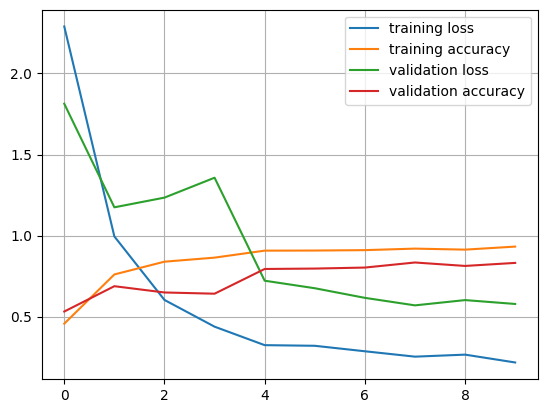

In [38]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [ ]:
# Evaluate the model on the Validation dataset
results = model.evaluate(val_datagen)

In [ ]:
train_results = model.evaluate(train_datagen)

In [ ]:
print("Training Loss :-", train_results[0])
print("="*30)
print("Training Accuracy :-", train_results[1])

In [ ]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

It's essential to compare the validation loss with the training loss. If the training loss is significantly lower than the validation loss, it might suggest overfitting. Ideally, the training and validation losses should be close, indicating good generalization.

**Saving the Model**

In [41]:
model.save('models/pdd_mobilenet2_v1.h5')

In [42]:
cd '/content/drive/My Drive/FloraGuard/datasets'

/content/drive/My Drive/FloraGuard/datasets


# Testing the Model

In [69]:
import random
from PIL import Image
import glob

base_path = 'plantvillage splitted'
idx = np.random.randint(30)
test_images_dir = os.path.join(base_path, 'test')

# Get a list of subdirectories within the test_images_dir
subdirectories = [d for d in os.listdir(test_images_dir) if os.path.isdir(os.path.join(test_images_dir, d))]

# Choose a random subdirectory
random_subdirectory = random.choice(subdirectories)

# Get a list of image files within the chosen subdirectory
image_files = glob.glob(os.path.join(test_images_dir, random_subdirectory, '*.jpg'))

if image_files:
    # Choose a random image file from the list
    random_image = random.choice(image_files)

    # Open the random image file
    test1 = Image.open(random_image)
else:
    print("No image files found in the directory:", os.path.join(test_images_dir, random_subdirectory))


Text(0.5, 1.0, 'Tomato___Early_blight')

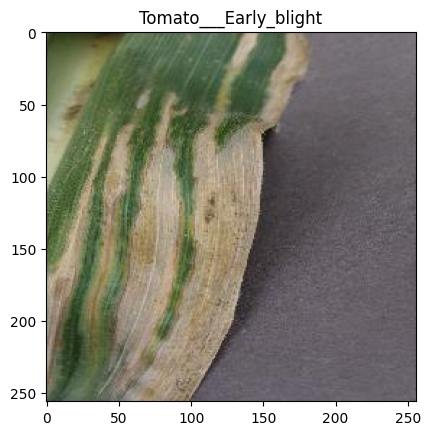

In [70]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

Predicting the Disease

In [71]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = model.predict(test1_scaled)
print(predictions)

1/1 [==============================] - 1s 1s/step
[[4.3431792e-02 7.8348047e-04 1.0280910e-02 1.2354388e-01 8.9246861e-04
  6.4324401e-02 6.7565270e-04 2.0250853e-02 3.6696646e-01 1.0183617e-01
  2.7556377e-02 1.5571832e-05 1.0580109e-05 1.2183305e-04 1.4608941e-04
  6.7081745e-03 4.4031516e-05 1.2160484e-04 2.0599710e-04 8.5795175e-05
  8.0242316e-05 4.3083372e-05 1.5703695e-04 2.3710505e-04 1.7310967e-01
  1.4570414e-02 8.3301328e-03 1.2191331e-02 2.1515479e-03 9.4543422e-05
  1.3625498e-02 3.7157495e-04 2.9992615e-04 2.2865451e-04 6.3454507e-05
  6.3229818e-03 4.5441015e-05 7.5251824e-05]]


In [72]:
labels = train_datagen.class_indices
labels = { v:k for (k,v) in labels.items() }
labels[np.argmax(predictions)]

'Corn_(maize)___Common_rust_'

In [73]:
cd '/content/drive/MyDrive/FloraGuard'

/content/drive/MyDrive/FloraGuard


In [74]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("models/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [76]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("models/converted_model.tflite", "wb").write(tflite_model)

16282648

# Deploying with Tensorflowjs

This will be achieved by converting the Python model to a Javascript-compatible format, using ‘ tensorflowjs-converter’ — An efficient Python module that converts saved Keras models to formats compatible with Javascript.

In [77]:
# Converting the Keras Model to Tensorflow.js compatible model
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
  Attempting uninstall: ml-dtypes
    

In [78]:
pwd

'/content/drive/MyDrive/FloraGuard'

In [79]:
!mkdir tensorflowjs-model2

In [84]:
!tensorflowjs_converter --input_format keras models/models/pdd_mobilenet2_v1.h5 tensorflowjs-model2/

2024-03-25 17:20:38.225644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [85]:
# Download the converted model
!zip -r tensorflowjs-model2.zip tensorflowjs-model2

  adding: tensorflowjs-model2/ (stored 0%)
  adding: tensorflowjs-model2/group1-shard1of4.bin (deflated 7%)
  adding: tensorflowjs-model2/group1-shard2of4.bin (deflated 7%)
  adding: tensorflowjs-model2/group1-shard3of4.bin (deflated 7%)
  adding: tensorflowjs-model2/group1-shard4of4.bin (deflated 8%)
  adding: tensorflowjs-model2/model.json (deflated 96%)
